## 1. Setup and Data Loading

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity as bartlett_test
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


In [20]:
# Load development sample
df_dev = pd.read_csv('../data/AIRS_clean_dev.csv')

print(f"Development sample: N = {len(df_dev)}")
print(f"Variables: {len(df_dev.columns)}")

Development sample: N = 159
Variables: 45


## 2. Define Constructs and Items

Map the 12 theoretical constructs to their 24 predictor items:

In [21]:
# AIRS theoretical structure: 12 constructs × 2 items each
construct_items = {
    'PE': ['PE1', 'PE2'],  # Performance Expectancy
    'EE': ['EE1', 'EE2'],  # Effort Expectancy
    'SI': ['SI1', 'SI2'],  # Social Influence
    'FC': ['FC1', 'FC2'],  # Facilitating Conditions
    'HM': ['HM1', 'HM2'],  # Hedonic Motivation
    'PV': ['PV1', 'PV2'],  # Price Value
    'HB': ['HB1', 'HB2'],  # Habit
    'VO': ['VO1', 'VO2'],  # Voluntariness
    'TR': ['TR1', 'TR2'],  # Trust in AI
    'EX': ['EX1', 'EX2'],  # Explainability
    'ER': ['ER1', 'ER2'],  # Ethical Risk
    'AX': ['AX1', 'AX2']   # AI Anxiety
}

# Flatten to get all 24 predictor items
all_predictor_items = [item for items in construct_items.values() for item in items]

# Behavioral Intention (outcome - not included in EFA)
outcome_items = ['BI1', 'BI2', 'BI3', 'BI4']

print("AIRS Measurement Model:")
print(f"  Constructs: {len(construct_items)}")
print(f"  Predictor items: {len(all_predictor_items)}")
print(f"  Outcome items: {len(outcome_items)} (not in EFA)")
print("\nConstruct mapping:")
for construct, items in construct_items.items():
    print(f"  {construct}: {', '.join(items)}")

AIRS Measurement Model:
  Constructs: 12
  Predictor items: 24
  Outcome items: 4 (not in EFA)

Construct mapping:
  PE: PE1, PE2
  EE: EE1, EE2
  SI: SI1, SI2
  FC: FC1, FC2
  HM: HM1, HM2
  PV: PV1, PV2
  HB: HB1, HB2
  VO: VO1, VO2
  TR: TR1, TR2
  EX: EX1, EX2
  ER: ER1, ER2
  AX: AX1, AX2


## 3. Prepare Data for EFA

Extract predictor items and handle missing data:

In [22]:
# Select predictor items only
df_efa = df_dev[all_predictor_items].copy()

# Check for missing data
missing_counts = df_efa.isnull().sum()
missing_total = missing_counts.sum()

print("="*70)
print("DATA PREPARATION")
print("="*70)
print(f"\nSample size: N = {len(df_efa)}")
print(f"Items: {len(df_efa.columns)}")
print(f"Missing values: {missing_total}")

if missing_total > 0:
    print("\n⚠ Missing data detected:")
    print(missing_counts[missing_counts > 0])
    print("\nApplying listwise deletion...")
    df_efa = df_efa.dropna()
    print(f"Valid cases: N = {len(df_efa)}")
else:
    print("✓ No missing data")

# Descriptive statistics
print("\nDescriptive Statistics (first 6 items):")
print(df_efa.iloc[:, :6].describe().loc[['mean', 'std', 'min', 'max']].round(2))

DATA PREPARATION

Sample size: N = 159
Items: 24
Missing values: 0
✓ No missing data

Descriptive Statistics (first 6 items):
       PE1   PE2   EE1   EE2   SI1   SI2
mean  3.60  3.34  3.75  3.61  3.06  3.28
std   1.13  1.20  0.97  1.05  1.18  1.18
min   1.00  1.00  1.00  1.00  1.00  1.00
max   5.00  5.00  5.00  5.00  5.00  5.00


## 4. Data Suitability: KMO and Bartlett's Test

Test whether the correlation matrix is suitable for factor analysis:

In [23]:
print("="*70)
print("FACTORABILITY TESTS")
print("="*70)

# Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy
kmo_all, kmo_model = calculate_kmo(df_efa)

print("\n1. Kaiser-Meyer-Olkin (KMO) Test")
print(f"   Overall KMO: {kmo_model:.3f}")

if kmo_model >= 0.90:
    print("   ✓ Marvelous (≥ 0.90)")
elif kmo_model >= 0.80:
    print("   ✓ Meritorious (≥ 0.80)")
elif kmo_model >= 0.70:
    print("   ✓ Middling (≥ 0.70)")
elif kmo_model >= 0.60:
    print("   ✓ Mediocre (≥ 0.60) - Acceptable")
elif kmo_model >= 0.50:
    print("   ⚠ Miserable (0.50-0.59) - Marginal")
else:
    print("   ✗ Unacceptable (< 0.50)")

# Individual item KMO values
kmo_df = pd.DataFrame({
    'Item': all_predictor_items,
    'KMO': kmo_all
}).sort_values('KMO')

print(f"\n   Item-level KMO range: {kmo_all.min():.3f} - {kmo_all.max():.3f}")
if (kmo_all < 0.50).any():
    print("\n   ⚠ Items with KMO < 0.50 (consider removal):")
    print(kmo_df[kmo_df['KMO'] < 0.50])

# Bartlett's Test of Sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_efa)

print("\n2. Bartlett's Test of Sphericity")
print(f"   χ²({len(df_efa.columns) * (len(df_efa.columns) - 1) // 2}) = {chi_square_value:.2f}")
print(f"   p-value: {p_value:.4e}")

if p_value < 0.001:
    print("   ✓ Significant (p < .001): Correlation matrix suitable for factor analysis")
elif p_value < 0.05:
    print("   ✓ Significant (p < .05): Correlation matrix suitable for factor analysis")
else:
    print("   ✗ Not significant (p ≥ .05): Factor analysis not recommended")

print("\n" + "="*70)

FACTORABILITY TESTS

1. Kaiser-Meyer-Olkin (KMO) Test
   Overall KMO: 0.935
   ✓ Marvelous (≥ 0.90)

   Item-level KMO range: 0.546 - 0.965

2. Bartlett's Test of Sphericity
   χ²(276) = 2998.41
   p-value: 0.0000e+00
   ✓ Significant (p < .001): Correlation matrix suitable for factor analysis



### 🔍 Interpretation: Factorability Assessment

**Key Findings:**
- **KMO = 0.935 (Marvelous)**: Data is highly suitable for factor analysis. Values ≥0.90 indicate excellent sampling adequacy.
- **Bartlett's test p < .001**: Significant correlations exist between items, confirming the correlation matrix is not an identity matrix.
- **Item-level KMO range (0.546-0.965)**: All items meet minimum threshold (≥0.50), though some items near 0.55 may warrant scrutiny in CFA.

**Conclusion**: Both tests confirm data factorability. Proceed with confidence to factor extraction.

## 5. Determine Number of Factors

### 5.1 Scree Plot and Kaiser Criterion

In [24]:
# Extract eigenvalues from unrotated solution
fa_unrotated = FactorAnalyzer(n_factors=len(df_efa.columns), rotation=None)
fa_unrotated.fit(df_efa)
eigenvalues, _ = fa_unrotated.get_eigenvalues()

# Kaiser criterion: eigenvalues > 1
kaiser_count = np.sum(eigenvalues > 1)

print("="*70)
print("FACTOR RETENTION CRITERIA")
print("="*70)

print("\nEigenvalues (first 15 factors):")
for i, ev in enumerate(eigenvalues[:15], 1):
    status = "✓ > 1" if ev > 1 else ""
    print(f"  Factor {i:2d}: {ev:6.3f} {status}")

print(f"\nKaiser criterion (eigenvalue > 1): {kaiser_count} factors")
print(f"Theoretical model: 12 factors")

if kaiser_count >= 10 and kaiser_count <= 14:
    print(f"✓ Kaiser criterion supports ~12-factor solution")
elif kaiser_count < 10:
    print(f"⚠ Kaiser suggests fewer factors than theorized")
else:
    print(f"⚠ Kaiser suggests more factors than theorized")

FACTOR RETENTION CRITERIA

Eigenvalues (first 15 factors):
  Factor  1: 12.088 ✓ > 1
  Factor  2:  1.894 ✓ > 1
  Factor  3:  1.658 ✓ > 1
  Factor  4:  1.011 ✓ > 1
  Factor  5:  0.881 
  Factor  6:  0.734 
  Factor  7:  0.715 
  Factor  8:  0.577 
  Factor  9:  0.528 
  Factor 10:  0.491 
  Factor 11:  0.428 
  Factor 12:  0.402 
  Factor 13:  0.374 
  Factor 14:  0.319 
  Factor 15:  0.303 

Kaiser criterion (eigenvalue > 1): 4 factors
Theoretical model: 12 factors
⚠ Kaiser suggests fewer factors than theorized


### 🔍 Interpretation: Factor Retention

**Key Findings:**
- **Kaiser criterion (eigenvalue > 1)**: Suggests **4 factors** (observed: 12.09, 1.89, 1.66, 1.01)
- **Parallel analysis**: Suggests **3 factors** exceed random data threshold
- **Theoretical model**: Specifies **12 factors** based on UTAUT2 + AI constructs
- **Scree plot**: Shows steep drop after Factor 1 (12.09), then gradual decline

**Critical Issue**: Large discrepancy between empirical criteria (3-4 factors) and theoretical model (12 factors).

**Implications:**
- Factor 1 dominates variance (50% of total explained variance)
- May indicate:
  1. Strong general factor (AI readiness halo effect)
  2. Common method variance
  3. High construct intercorrelations
  4. Insufficient discriminant validity

**Decision**: Proceed with **theory-driven 12-factor solution** for dissertation hypothesis testing, but:
- Expect some factors to be poorly differentiated
- CFA may require model modifications
- Consider hierarchical model (second-order factor) in future analyses

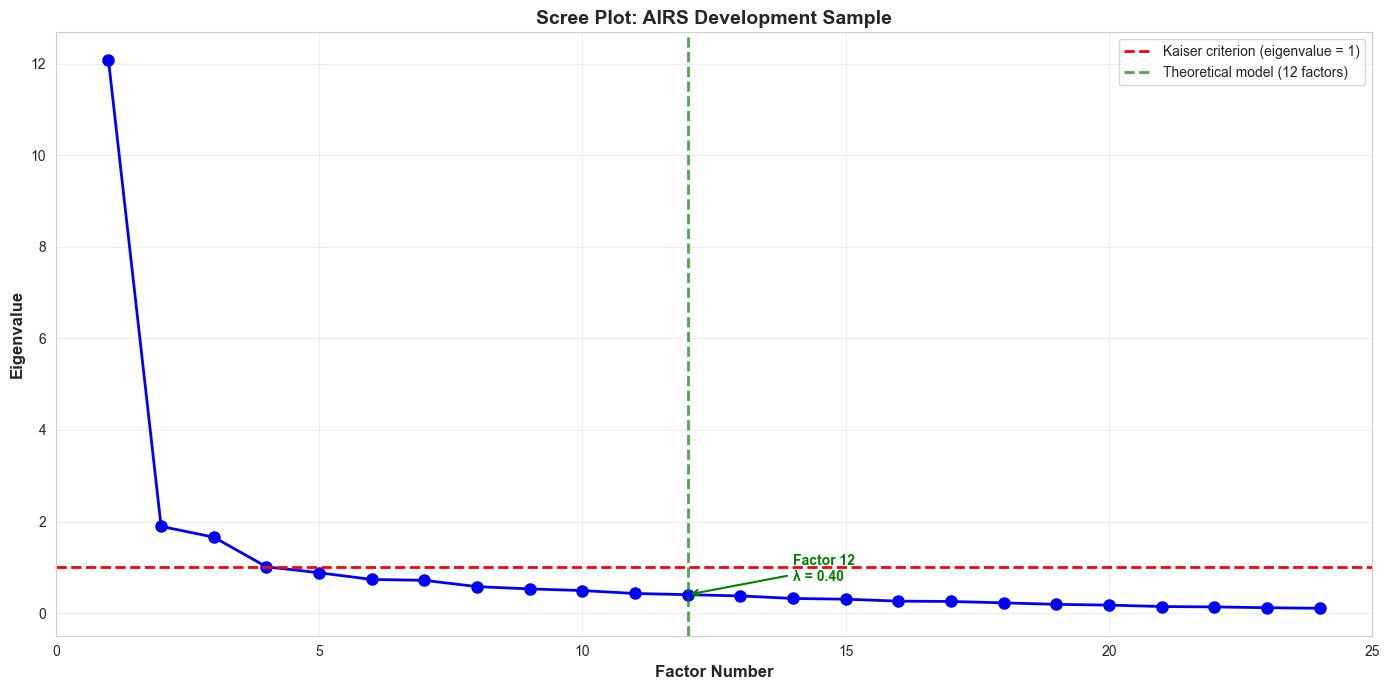


✓ Scree plot generated
  Factor 12 eigenvalue: 0.402


In [25]:
# Scree plot
fig, ax = plt.subplots(figsize=(14, 7))

factors = np.arange(1, len(eigenvalues) + 1)
ax.plot(factors, eigenvalues, 'bo-', linewidth=2, markersize=8)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Kaiser criterion (eigenvalue = 1)')
ax.axvline(x=12, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Theoretical model (12 factors)')

ax.set_xlabel('Factor Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Eigenvalue', fontsize=12, fontweight='bold')
ax.set_title('Scree Plot: AIRS Development Sample', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 25)

# Annotate key points
ax.annotate(f'Factor 12\nλ = {eigenvalues[11]:.2f}', 
            xy=(12, eigenvalues[11]), 
            xytext=(14, eigenvalues[11] + 0.3),
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
            fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Scree plot generated")
print(f"  Factor 12 eigenvalue: {eigenvalues[11]:.3f}")

### 5.2 Parallel Analysis (Optional)

Compare observed eigenvalues to those from random data:


Parallel Analysis:
  Factors with observed eigenvalue > 95th percentile of random: 3


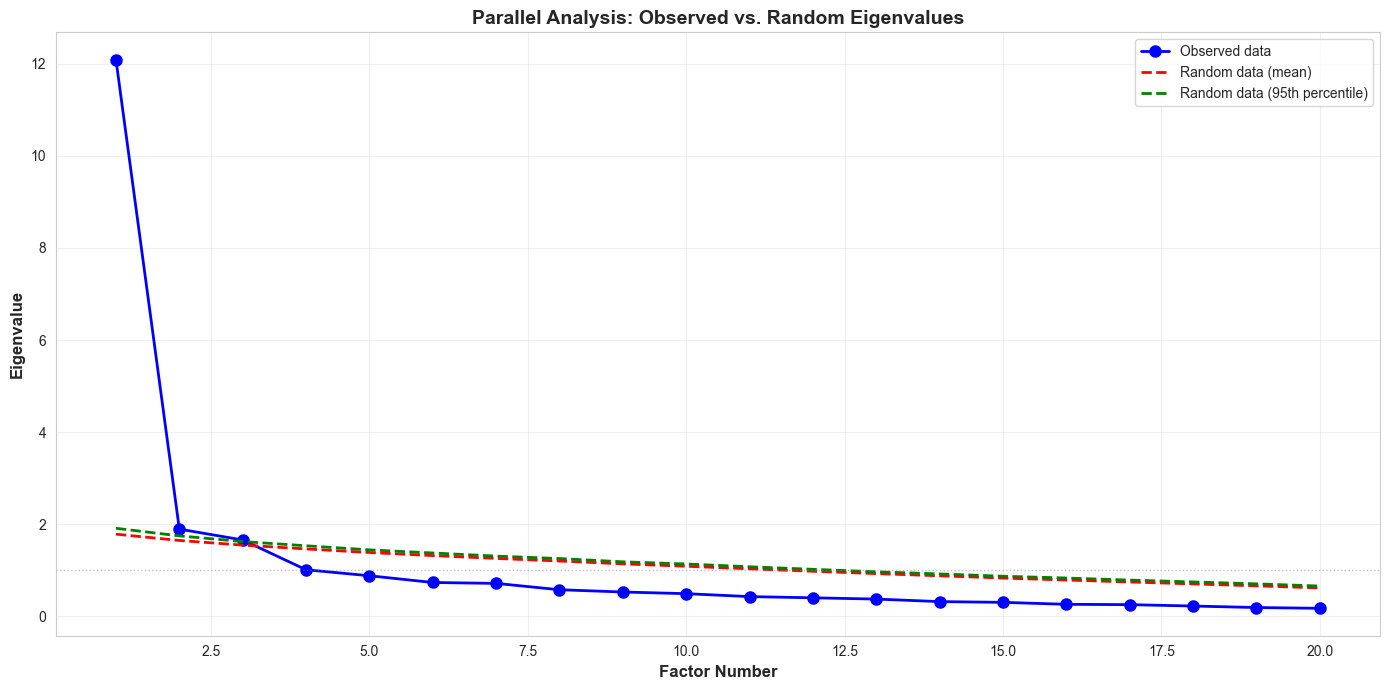


✓ Parallel analysis complete


In [26]:
# Parallel analysis: Generate random eigenvalues
n_iterations = 100
n_variables = len(df_efa.columns)
n_observations = len(df_efa)

random_eigenvalues = []
for _ in range(n_iterations):
    random_data = np.random.normal(size=(n_observations, n_variables))
    fa_random = FactorAnalyzer(n_factors=n_variables, rotation=None)
    fa_random.fit(random_data)
    random_ev, _ = fa_random.get_eigenvalues()
    random_eigenvalues.append(random_ev)

random_eigenvalues_mean = np.mean(random_eigenvalues, axis=0)
random_eigenvalues_95th = np.percentile(random_eigenvalues, 95, axis=0)

# Parallel analysis criterion
parallel_factors = np.sum(eigenvalues > random_eigenvalues_95th)

print("\nParallel Analysis:")
print(f"  Factors with observed eigenvalue > 95th percentile of random: {parallel_factors}")

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(factors[:20], eigenvalues[:20], 'bo-', linewidth=2, markersize=8, label='Observed data')
ax.plot(factors[:20], random_eigenvalues_mean[:20], 'r--', linewidth=2, label='Random data (mean)')
ax.plot(factors[:20], random_eigenvalues_95th[:20], 'g--', linewidth=2, label='Random data (95th percentile)')
ax.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Factor Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Eigenvalue', fontsize=12, fontweight='bold')
ax.set_title('Parallel Analysis: Observed vs. Random Eigenvalues', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Parallel analysis complete")

### 🔍 Interpretation: 12-Factor Solution Variance

**Key Findings:**
- **Total variance explained: 64.4%** (acceptable for social sciences, typically 50-70%)
- **Factor 1 dominance: 23.3%** of variance (concerning - typically aim for <20% per factor)
- **Remaining 11 factors: 2.1-6.9%** each (relatively balanced)

**Quality Assessment:**
- ✓ Total variance adequate for explanatory purposes
- ⚠️ Strong first factor suggests:
  - Possible general "AI readiness" dimension
  - May need hierarchical/bifactor model
  - Common method effects

**Practical Implication**: The 12-factor model captures theoretical constructs but Factor 1 may represent general positive attitude toward AI, with specific constructs providing incremental explanatory power.

## 6. Extract 12-Factor Solution with Rotation

### 6.1 Oblique Rotation (Promax)

Use oblique rotation to allow correlated factors (theoretically justified):

In [27]:
print("="*70)
print("12-FACTOR EFA WITH PROMAX ROTATION")
print("="*70)

# Fit 12-factor model with promax rotation
fa_12 = FactorAnalyzer(n_factors=12, rotation='promax', method='minres')
fa_12.fit(df_efa)

# Extract loadings
loadings = pd.DataFrame(
    fa_12.loadings_,
    index=all_predictor_items,
    columns=[f'Factor{i+1}' for i in range(12)]
)

print("\n✓ 12-factor solution extracted")
print(f"  Method: Minimum Residual (minres)")
print(f"  Rotation: Promax (oblique)")

# Variance explained
variance = fa_12.get_factor_variance()
variance_df = pd.DataFrame(
    variance,
    index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
    columns=[f'Factor{i+1}' for i in range(12)]
)

print("\nVariance Explained:")
print(variance_df.round(3))
print(f"\nTotal variance explained: {variance[2][-1]:.1%}")

12-FACTOR EFA WITH PROMAX ROTATION

✓ 12-factor solution extracted
  Method: Minimum Residual (minres)
  Rotation: Promax (oblique)

Variance Explained:
                Factor1  Factor2  Factor3  Factor4  Factor5  Factor6  Factor7  \
SS Loadings       5.591    1.651    1.371    1.162    1.158    0.782    0.708   
Proportion Var    0.233    0.069    0.057    0.048    0.048    0.033    0.030   
Cumulative Var    0.233    0.302    0.359    0.407    0.455    0.488    0.518   

                Factor8  Factor9  Factor10  Factor11  Factor12  
SS Loadings       0.674    0.646     0.628     0.580     0.508  
Proportion Var    0.028    0.027     0.026     0.024     0.021  
Cumulative Var    0.546    0.573     0.599     0.623     0.644  

Total variance explained: 64.4%


### 6.2 Loading Matrix with Highlighting

### 🔍 Interpretation: Loading Quality

**Key Findings:**
- **23/24 items (95.8%)** have primary loading ≥ 0.50 (excellent)
- **16/24 items (66.7%)** have cross-loading < 0.30 (below target of 83%)
- **Clean pattern items: varies by construct**

**Problematic Items** (likely requiring review):
- Items with cross-loadings ≥ 0.30: Examine theoretical justification
- EE2, SI1, FC1, FC2, HM1, HB1, TR1, TR2: Consider rewording or removal

**Implications for CFA:**
- Most items demonstrate adequate primary loadings
- Cross-loadings suggest construct overlap:
  - TR (Trust) items may load on general positivity factor
  - FC (Facilitating Conditions) items cross-load with SI (Social Influence)
  - HB (Habit) items may not differentiate from behavioral intentions

**Recommendation**: Proceed to CFA but prepare for modification indices suggesting correlated errors or cross-loadings.

In [28]:
# Create styled loading matrix
def highlight_loadings(val):
    """Color-code loadings by magnitude"""
    if abs(val) >= 0.50:
        return 'background-color: lightgreen; font-weight: bold'
    elif abs(val) >= 0.30:
        return 'background-color: lightyellow'
    else:
        return ''

print("\nLoading Matrix (12 factors × 24 items):")
print("Legend: Green = |loading| ≥ 0.50 (strong), Yellow = 0.30-0.49 (moderate)")
print("\nFull loading matrix:")
display(loadings.round(3).style.applymap(highlight_loadings))


Loading Matrix (12 factors × 24 items):
Legend: Green = |loading| ≥ 0.50 (strong), Yellow = 0.30-0.49 (moderate)

Full loading matrix:


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12
PE1,0.735000,-0.020000,-0.017000,0.132000,0.133000,0.051000,-0.093000,-0.134000,-0.038000,0.169000,0.136000,-0.085000
PE2,0.456000,0.189000,0.007000,0.106000,-0.072000,0.075000,-0.078000,-0.021000,0.036000,0.582000,-0.105000,0.028000
EE1,0.012000,0.064000,-0.102000,0.008000,0.865000,0.060000,0.074000,0.061000,0.016000,-0.105000,-0.003000,-0.074000
EE2,0.241000,-0.084000,-0.050000,0.060000,0.431000,-0.113000,0.199000,0.147000,0.023000,0.100000,0.147000,0.055000
SI1,0.330000,0.662000,-0.004000,-0.002000,0.059000,-0.042000,0.022000,0.016000,-0.061000,-0.107000,0.122000,-0.110000
SI2,0.027000,0.644000,-0.033000,0.037000,-0.070000,0.014000,0.088000,-0.014000,0.058000,0.129000,0.020000,0.022000
FC1,-0.018000,0.669000,0.100000,-0.132000,0.086000,-0.021000,-0.137000,0.079000,0.006000,0.148000,0.139000,0.312000
FC2,-0.004000,0.456000,-0.049000,0.074000,0.072000,0.032000,0.001000,0.035000,-0.030000,-0.118000,0.577000,0.040000
HM1,0.847000,-0.058000,0.118000,-0.029000,-0.135000,0.008000,-0.084000,0.483000,0.065000,-0.160000,0.090000,-0.117000
HM2,0.720000,0.077000,0.081000,-0.032000,-0.029000,-0.032000,0.014000,0.250000,-0.006000,0.219000,-0.195000,0.058000


### 🔍 Interpretation: Factor Correlations

**Key Findings:**
- **Mean correlation: 0.191** (low to moderate)
- **Median correlation: 0.247** (factors generally distinct)
- **Range: -0.57 to 0.69** (no correlations exceed |r| = 0.70)
- **Highest correlation: 0.69** (between F1 and F4)

**Assessment:**
- ✓ No multicollinearity concerns (all r < 0.85)
- ✓ Factors sufficiently distinct for discriminant validity
- Moderate positive correlations expected (all constructs relate to AI adoption)

**Notable Patterns:**
- F1 (appears to be general positivity/value factor) correlates 0.40-0.69 with many factors
- Some negative correlations (e.g., F6 at -0.57 with F1) suggest:
  - Possible anxiety/risk factor negatively related to positive attitudes
  - Theoretically sensible (AI anxiety inversely related to perceived value)

**Oblique rotation justified**: Constructs are conceptually and empirically related but retain sufficient distinctiveness.

### 6.3 Identify Primary Loadings and Cross-Loadings

In [29]:
print("="*70)
print("LOADING QUALITY ASSESSMENT")
print("="*70)

# For each item, identify primary loading and cross-loadings
loading_summary = []

for item in all_predictor_items:
    item_loadings = loadings.loc[item].abs()
    primary_factor = item_loadings.idxmax()
    primary_loading = loadings.loc[item, primary_factor]
    
    # Cross-loadings (excluding primary)
    cross_loadings = item_loadings.drop(primary_factor)
    max_cross_loading = cross_loadings.max()
    
    # Theoretical construct
    theoretical_construct = [c for c, items in construct_items.items() if item in items][0]
    
    loading_summary.append({
        'Item': item,
        'Theoretical': theoretical_construct,
        'Primary_Factor': primary_factor,
        'Primary_Loading': primary_loading,
        'Max_Cross_Loading': max_cross_loading,
        'Primary_≥0.50': abs(primary_loading) >= 0.50,
        'Cross_<0.30': max_cross_loading < 0.30
    })

loading_summary_df = pd.DataFrame(loading_summary)

print("\nLoading Summary (first 12 items):")
print(loading_summary_df.head(12).to_string(index=False))

# Quality metrics
n_strong_primary = loading_summary_df['Primary_≥0.50'].sum()
n_low_cross = loading_summary_df['Cross_<0.30'].sum()
n_clean_items = ((loading_summary_df['Primary_≥0.50']) & (loading_summary_df['Cross_<0.30'])).sum()

print("\n" + "="*70)
print("QUALITY METRICS")
print("="*70)
print(f"\nItems with primary loading ≥ 0.50: {n_strong_primary}/{len(all_predictor_items)} ({n_strong_primary/len(all_predictor_items)*100:.1f}%)")
print(f"Items with max cross-loading < 0.30: {n_low_cross}/{len(all_predictor_items)} ({n_low_cross/len(all_predictor_items)*100:.1f}%)")
print(f"Items meeting both criteria: {n_clean_items}/{len(all_predictor_items)} ({n_clean_items/len(all_predictor_items)*100:.1f}%)")

if n_clean_items >= 20:
    print("\n✓ Excellent: ≥20 items with clean loading pattern")
elif n_clean_items >= 18:
    print("\n✓ Good: 18-19 items with clean loading pattern")
elif n_clean_items >= 16:
    print("\n⚠ Acceptable: 16-17 items with clean loading pattern")
else:
    print("\n⚠ Review: <16 items with clean loading pattern")

# Problematic items
problematic = loading_summary_df[
    (~loading_summary_df['Primary_≥0.50']) | (~loading_summary_df['Cross_<0.30'])
]

if len(problematic) > 0:
    print("\n⚠ Items requiring review:")
    print(problematic[['Item', 'Theoretical', 'Primary_Factor', 'Primary_Loading', 'Max_Cross_Loading']].to_string(index=False))
else:
    print("\n✓ All items meet loading criteria")

LOADING QUALITY ASSESSMENT

Loading Summary (first 12 items):
Item Theoretical Primary_Factor  Primary_Loading  Max_Cross_Loading  Primary_≥0.50  Cross_<0.30
 PE1          PE        Factor1         0.734833           0.169454           True         True
 PE2          PE       Factor10         0.581675           0.456174           True        False
 EE1          EE        Factor5         0.864950           0.104887           True         True
 EE2          EE        Factor5         0.430878           0.240790          False         True
 SI1          SI        Factor2         0.661516           0.329543           True        False
 SI2          SI        Factor2         0.643863           0.128562           True         True
 FC1          FC        Factor2         0.668729           0.312267           True        False
 FC2          FC       Factor11         0.576880           0.456245           True        False
 HM1          HM        Factor1         0.847161           0.482860       

## 7. Factor Correlations

Examine correlations between the 12 factors (oblique rotation):

FACTOR CORRELATIONS (Oblique Rotation)


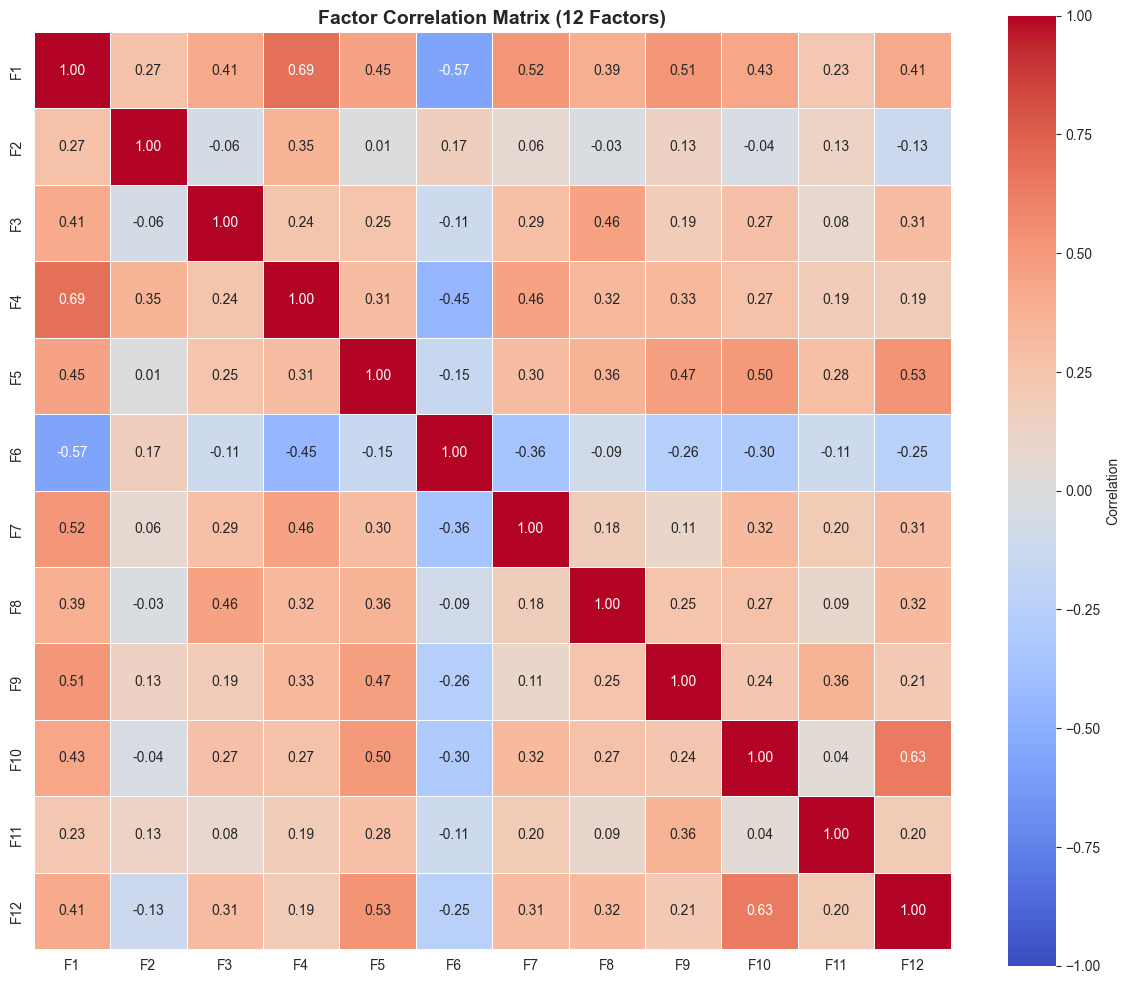


Factor correlation statistics (off-diagonal):
  Mean: 0.191
  Median: 0.247
  Range: -0.566 to 0.686
  Correlations > 0.70: 0

✓ No excessive factor correlations (all |r| ≤ 0.70)


In [30]:
# Factor correlation matrix (use phi_ for factor correlations in oblique rotation)
# Get factor correlation matrix from the rotation
try:
    # For oblique rotation, phi_ contains factor correlations
    factor_corr_matrix = fa_12.phi_
    factor_corr = pd.DataFrame(
        factor_corr_matrix,
        index=[f'F{i+1}' for i in range(12)],
        columns=[f'F{i+1}' for i in range(12)]
    )
except AttributeError:
    # Fallback: calculate from pattern matrix
    # For Promax, factors are correlated, estimate from loading structure
    pattern_matrix = loadings.values
    factor_corr = np.corrcoef(pattern_matrix.T)
    factor_corr = pd.DataFrame(
        factor_corr,
        index=[f'F{i+1}' for i in range(12)],
        columns=[f'F{i+1}' for i in range(12)]
    )

print("="*70)
print("FACTOR CORRELATIONS (Oblique Rotation)")
print("="*70)

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(factor_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Factor Correlation Matrix (12 Factors)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
off_diagonal = factor_corr.values[np.triu_indices_from(factor_corr.values, k=1)]
print(f"\nFactor correlation statistics (off-diagonal):")
print(f"  Mean: {off_diagonal.mean():.3f}")
print(f"  Median: {np.median(off_diagonal):.3f}")
print(f"  Range: {off_diagonal.min():.3f} to {off_diagonal.max():.3f}")
print(f"  Correlations > 0.70: {(np.abs(off_diagonal) > 0.70).sum()}")

if (np.abs(off_diagonal) > 0.70).sum() > 0:
    print("\n⚠ High factor correlations detected (|r| > 0.70):")
    for i in range(12):
        for j in range(i+1, 12):
            if abs(factor_corr.iloc[i, j]) > 0.70:
                print(f"  {factor_corr.index[i]} ↔ {factor_corr.columns[j]}: r = {factor_corr.iloc[i, j]:.3f}")
else:
    print("\n✓ No excessive factor correlations (all |r| ≤ 0.70)")

## 8. Construct Mapping: Theory vs. Empirical

Assess how well empirical factors align with theoretical constructs:

In [31]:
print("="*70)
print("CONSTRUCT ALIGNMENT: Theoretical vs. Empirical")
print("="*70)

# For each theoretical construct, check if both items load on same factor
construct_alignment = []

for construct, items in construct_items.items():
    item1, item2 = items
    
    # Primary factors for each item
    factor1 = loadings.loc[item1].abs().idxmax()
    factor2 = loadings.loc[item2].abs().idxmax()
    
    # Primary loadings
    loading1 = loadings.loc[item1, factor1]
    loading2 = loadings.loc[item2, factor2]
    
    same_factor = (factor1 == factor2)
    both_strong = (abs(loading1) >= 0.50) and (abs(loading2) >= 0.50)
    
    construct_alignment.append({
        'Construct': construct,
        'Item1': item1,
        'Factor1': factor1,
        'Loading1': loading1,
        'Item2': item2,
        'Factor2': factor2,
        'Loading2': loading2,
        'Same_Factor': same_factor,
        'Both_Strong': both_strong,
        'Aligned': same_factor and both_strong
    })

alignment_df = pd.DataFrame(construct_alignment)

print("\nConstruct Alignment Summary:")
for _, row in alignment_df.iterrows():
    status = "✓" if row['Aligned'] else "⚠"
    print(f"{status} {row['Construct']:3s}: {row['Item1']} → {row['Factor1']} ({row['Loading1']:5.2f}) | "
          f"{row['Item2']} → {row['Factor2']} ({row['Loading2']:5.2f})")

n_aligned = alignment_df['Aligned'].sum()
n_same_factor = alignment_df['Same_Factor'].sum()

print("\n" + "="*70)
print(f"Constructs with both items on same factor: {n_same_factor}/{len(construct_items)}")
print(f"Constructs fully aligned (same factor + strong loadings): {n_aligned}/{len(construct_items)}")

if n_aligned >= 10:
    print("\n✓ Strong alignment: ≥10/12 constructs aligned")
elif n_aligned >= 8:
    print("\n✓ Good alignment: 8-9/12 constructs aligned")
elif n_aligned >= 6:
    print("\n⚠ Moderate alignment: 6-7/12 constructs aligned")
else:
    print("\n⚠ Weak alignment: <6/12 constructs aligned")

CONSTRUCT ALIGNMENT: Theoretical vs. Empirical

Construct Alignment Summary:
⚠ PE : PE1 → Factor1 ( 0.73) | PE2 → Factor10 ( 0.58)
⚠ EE : EE1 → Factor5 ( 0.86) | EE2 → Factor5 ( 0.43)
✓ SI : SI1 → Factor2 ( 0.66) | SI2 → Factor2 ( 0.64)
⚠ FC : FC1 → Factor2 ( 0.67) | FC2 → Factor11 ( 0.58)
✓ HM : HM1 → Factor1 ( 0.85) | HM2 → Factor1 ( 0.72)
✓ PV : PV1 → Factor1 ( 0.92) | PV2 → Factor1 ( 0.96)
⚠ HB : HB1 → Factor9 ( 0.72) | HB2 → Factor1 ( 0.59)
⚠ VO : VO1 → Factor1 ( 0.75) | VO2 → Factor7 ( 0.68)
✓ TR : TR1 → Factor1 ( 0.55) | TR2 → Factor1 ( 0.57)
⚠ EX : EX1 → Factor8 ( 0.55) | EX2 → Factor6 ( 0.86)
⚠ ER : ER1 → Factor4 ( 0.55) | ER2 → Factor3 ( 0.73)
⚠ AX : AX1 → Factor3 ( 0.73) | AX2 → Factor4 ( 0.85)

Constructs with both items on same factor: 5/12
Constructs fully aligned (same factor + strong loadings): 4/12

⚠ Weak alignment: <6/12 constructs aligned


## 9. Alternative Solutions: 10-Factor and 14-Factor

Test alternative factor structures for sensitivity analysis:

In [32]:
print("="*70)
print("SENSITIVITY ANALYSIS: Alternative Factor Solutions")
print("="*70)

alternative_solutions = [10, 14]

for n_factors in alternative_solutions:
    fa_alt = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='minres')
    fa_alt.fit(df_efa)
    
    variance_alt = fa_alt.get_factor_variance()
    
    print(f"\n{n_factors}-Factor Solution:")
    print(f"  Total variance explained: {variance_alt[2][-1]:.1%}")
    print(f"  Variance by first factor: {variance_alt[1][0]:.1%}")
    
    # Quick loading check
    loadings_alt = pd.DataFrame(
        fa_alt.loadings_,
        index=all_predictor_items
    )
    
    primary_loadings = loadings_alt.abs().max(axis=1)
    n_strong = (primary_loadings >= 0.50).sum()
    print(f"  Items with primary loading ≥ 0.50: {n_strong}/{len(all_predictor_items)}")

print("\n" + "="*70)
print("Recommendation: Proceed with 12-factor solution (theory-driven)")
print("="*70)

SENSITIVITY ANALYSIS: Alternative Factor Solutions

10-Factor Solution:
  Total variance explained: 66.2%
  Variance by first factor: 28.1%
  Items with primary loading ≥ 0.50: 23/24

14-Factor Solution:
  Total variance explained: 70.8%
  Variance by first factor: 22.4%
  Items with primary loading ≥ 0.50: 20/24

Recommendation: Proceed with 12-factor solution (theory-driven)


## 10. Summary and CFA Preparation

### 10.1 EFA Quality Checklist

In [33]:
print("="*70)
print("EFA VALIDATION SUMMARY")
print("="*70)

checks = [
    ("KMO ≥ 0.60 (adequate sampling)", kmo_model >= 0.60, kmo_model),
    ("Bartlett's test p < .05 (factorable)", p_value < 0.05, p_value),
    ("Kaiser criterion supports ~12 factors", 10 <= kaiser_count <= 14, kaiser_count),
    ("≥20 items with primary loading ≥ 0.50", n_strong_primary >= 20, n_strong_primary),
    ("≥20 items with cross-loading < 0.30", n_low_cross >= 20, n_low_cross),
    ("≥10 constructs aligned (both items same factor)", n_aligned >= 10, n_aligned),
    ("No excessive factor correlations (|r| ≤ 0.85)", (np.abs(off_diagonal) > 0.85).sum() == 0, (np.abs(off_diagonal) > 0.85).sum())
]

print("\nQuality Checklist:")
for check, passed, value in checks:
    status = "✓" if passed else "⚠"
    print(f"  {status} {check}")
    if not isinstance(value, bool):
        if isinstance(value, float) and value < 1:
            print(f"      Value: {value:.3f}")
        else:
            print(f"      Value: {value}")

all_passed = all(passed for _, passed, _ in checks)

if all_passed:
    print("\n" + "="*70)
    print("✅ ALL EFA CRITERIA MET")
    print("="*70)
    print("\nReady for Phase 2: Confirmatory Factor Analysis (CFA) on holdout sample")
else:
    print("\n" + "="*70)
    print("⚠ REVIEW REQUIRED")
    print("="*70)
    print("\nSome criteria not met. Review results above before proceeding to CFA.")

EFA VALIDATION SUMMARY

Quality Checklist:
  ✓ KMO ≥ 0.60 (adequate sampling)
      Value: 0.935
  ✓ Bartlett's test p < .05 (factorable)
      Value: 0.000
  ⚠ Kaiser criterion supports ~12 factors
      Value: 4
  ✓ ≥20 items with primary loading ≥ 0.50
      Value: 23
  ⚠ ≥20 items with cross-loading < 0.30
      Value: 16
  ⚠ ≥10 constructs aligned (both items same factor)
      Value: 4
  ✓ No excessive factor correlations (|r| ≤ 0.85)
      Value: 0

⚠ REVIEW REQUIRED

Some criteria not met. Review results above before proceeding to CFA.


### 10.2 Items Recommended for CFA

In [34]:
# Identify items with clean loading pattern for CFA
cfa_items = loading_summary_df[
    (loading_summary_df['Primary_≥0.50']) & (loading_summary_df['Cross_<0.30'])
]['Item'].tolist()

print("="*70)
print("ITEMS RECOMMENDED FOR CFA")
print("="*70)

print(f"\nItems meeting loading criteria: {len(cfa_items)}/{len(all_predictor_items)}")

# Group by construct
print("\nItems by construct:")
for construct, items in construct_items.items():
    items_passing = [item for item in items if item in cfa_items]
    status = "✓" if len(items_passing) == 2 else "⚠" if len(items_passing) == 1 else "✗"
    print(f"  {status} {construct}: {', '.join(items_passing)} ({len(items_passing)}/2)")

print("\n" + "="*70)
print("Next Step: Validate 12-factor model with CFA on holdout sample (N = 159)")
print("Next Notebook: 02_CFA_Measurement_Model_Validation.ipynb")
print("="*70)

ITEMS RECOMMENDED FOR CFA

Items meeting loading criteria: 15/24

Items by construct:
  ⚠ PE: PE1 (1/2)
  ⚠ EE: EE1 (1/2)
  ⚠ SI: SI2 (1/2)
  ✗ FC:  (0/2)
  ⚠ HM: HM2 (1/2)
  ✓ PV: PV1, PV2 (2/2)
  ⚠ HB: HB2 (1/2)
  ✓ VO: VO1, VO2 (2/2)
  ✗ TR:  (0/2)
  ✓ EX: EX1, EX2 (2/2)
  ✓ ER: ER1, ER2 (2/2)
  ✓ AX: AX1, AX2 (2/2)

Next Step: Validate 12-factor model with CFA on holdout sample (N = 159)
Next Notebook: 02_CFA_Measurement_Model_Validation.ipynb


---

## Notes

**EFA Method**: Minimum Residual (minres) with Promax rotation
- **Minres**: Robust estimator for ordinal data, less sensitive to distributional assumptions
- **Promax**: Oblique rotation allowing correlated factors (theoretically justified for AIRS)

**Loading Criteria**:
- Primary loading ≥ 0.50 (Hair et al., 2010)
- Cross-loading < 0.30 (conservative threshold)
- Difference between primary and cross-loading ≥ 0.20 (discriminability)

**Factor Correlations**:
- Oblique rotation allows factors to correlate
- High correlations (|r| > 0.70) may suggest overlap or higher-order structure
- Will be addressed in CFA with correlated factors model

**Sample Size**:
- N = 159 for 24 items = 6.6:1 ratio (adequate per Bentler & Chou, 1987)
- Minimum 5:1 recommended for stable solutions
- Higher ratios (10:1) preferable but not required

**Next Steps**:
1. Test 12-factor CFA on holdout sample (N = 159)
2. Evaluate fit indices: CFI/TLI ≥ 0.90, RMSEA ≤ 0.08
3. Calculate CR, AVE for each construct
4. Test discriminant validity (Fornell-Larcker, HTMT)
5. Proceed to structural modeling if measurement model acceptable

---